# Digital Communication Systems Project: Implementation of LDPC Code

## Seungmin Kim
## EECS 20224026
### https://github.com/smin-k/Digital-Communication-Systems
### https://drive.google.com/file/d/12fdg7anOlGf18RMnZ3Pqftbm412EmCSk/view?usp=sharing

# Mission 1  
## Evaluate the bit error probability of the IEEE standard 802.16e LDPC code  

In [1]:
import math
import requests
from io import BytesIO
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.special import erfc
from PIL import Image
from numba import jit, prange
from IPython.display import HTML

def show_array(array):
    html = '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            ''.join('<td style="background-color: yellow;"><b>{}</b></td>'.format(_) if _ != 0 else '<td>{}</td>'.format(_) for _ in row) for row in array
        )
    )

    display(HTML(html))

# Parity Check Matrix: Choose a code rate 𝑅 and determine the base matrix

## I took and used all the default matrices provided in 802.16e.

## base matrix list

In [2]:
hb_matrix_12 = np.array([
    [-1,  94,  73,  -1,  -1,  -1,  -1,  -1,  55,  83,  -1,  -1,  7,    0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [-1,  27,  -1,  -1,  -1,  22,  79,   9,  -1,  -1,  -1,  12,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [-1,  -1,  -1,  24,  22,  81,  -1,  33,  -1,  -1,  -1,   0,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [61,  -1,  47,  -1,  -1,  -1,  -1,  -1,  65,  25,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
    [-1,  -1,  39,  -1,  -1,  -1,  84,  -1,  -1,  41,  72,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1],
    [-1,  -1,  -1,  -1,  46,  40,  -1,  82,  -1,  -1,  -1,  79,   0,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1],
    [-1,  -1,  95,  53,  -1,  -1,  -1,  -1,  -1,  14,  18,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1],
    [-1,  11,  73,  -1,  -1,  -1,   2,  -1,  -1,  47,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1],
    [12,  -1,  -1,  -1,  83,  24,  -1,  43,  -1,  -1,  -1,  51,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1],
    [-1,  -1,  -1,  -1,  -1,  94,  -1,  59,  -1,  -1,  70,  72,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1],
    [-1,  -1,   7,  65,  -1,  -1,  -1,  -1,  39,  49,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0],
    [43,  -1,  -1,  -1,  -1,  66,  -1,  41,  -1,  -1,  -1,  26,   7,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  0 ]
])

#23b
hb_matrix_23 = [
    [ 2,  -1,  19,  -1,  47,  -1,  48,  -1,  36,  -1,  82,  -1,  47,  -1,  15,  -1,  95,   0,  -1,  -1,  -1,  -1,  -1,  -1],
    [-1,  69,  -1,  88,  -1,  33,  -1,   3,  -1,  16,  -1,  37,  -1,  40,  -1,  48,  -1,   0,   0,  -1,  -1,  -1,  -1,  -1],
    [10,  -1,  86,  -1,  62,  -1,  28,  -1,  85,  -1,  16,  -1,  34,  -1,  73,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1,  -1],
    [-1,  28,  -1,  32,  -1,  81,  -1,  27,  -1,  88,  -1,   5,  -1,  56,  -1,  37,  -1,  -1,  -1,   0,   0,  -1,  -1,  -1],
    [23,  -1,  29,  -1,  15,  -1,  30,  -1,  66,  -1,  24,  -1,  50,  -1,  62,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1,  -1],
    [-1,  30,  -1,  65,  -1,  54,  -1,  14,  -1,   0,  -1,  30,  -1,  74,  -1,   0,  -1,  -1,  -1,  -1,  -1,   0,   0,  -1],
    [32,  -1,   0,  -1,  15,  -1,  56,  -1,  85,  -1,   5,  -1,   6,  -1,  52,  -1,   0,  -1,  -1,  -1,  -1,  -1,   0,   0],
    [-1,   0,  -1,  47,  -1,  13,  -1,  61,  -1,  84,  -1,  55,  -1,  78,  -1,  41,  95,  -1,  -1,  -1,  -1,  -1,  -1,   0]
]

#34a
hb_matrix_34 = np.array([
    [ 6,  38,   3,  93,  -1,  -1,  -1,  30,  70,  -1,  86,  -1,  37,  38,   4,  11,  -1,  46,  48,   0,  -1,  -1,  -1,  -1],
    [62,  94,  19,  84,  -1,  92,  78,  -1,  15,  -1,  -1,  92,  -1,  45,  24,  32,  30,  -1,  -1,   0,   0,  -1,  -1,  -1],
    [71,  -1,  55,  -1,  12,  66,  45,  79,  -1,  78,  -1,  -1,  10,  -1,  22,  55,  70,  82,  -1,  -1,   0,   0,  -1,  -1],
    [38,  61,  -1,  66,   9,  73,  47,  64,  -1,  39,  61,  43,  -1,  -1,  -1,  -1,  95,  32,   0,  -1,  -1,   0,   0,  -1],
    [-1,  -1,  -1,  -1,  32,  52,  55,  80,  95,  22,   6,  51,  24,  90,  44,  20,  -1,  -1,  -1,  -1,  -1,  -1,   0,   0],
    [-1,  63,  31,  88,  20,  -1,  -1,  -1,   6,  40,  56,  16,  71,  53,  -1,  -1,  27,  26,  48,  -1,  -1,  -1,  -1,   0]
])

hb_matrix_56 = np.array([
    [ 1, 25, 55, -1,  47,   4,  -1,  91,  84,   8,  86,  52,  82,  33,   5,   0,  36,  20,   4,  77,  80,   0,  -1,  -1],
    [-1,  6, -1, 36,  40,  47,  12,  79,  47,  -1,  41,  21,  12,  71,  14,  72,   0,  44,  49,   0,   0,   0,   0,  -1],
    [51, 81, 83,  4,  67,  -1,  21,  -1,  31,  24,  91,  61,  81,   9,  86,  78,  60,  88,  67,  15,  -1,  -1,   0,   0],
    [50, -1, 50, 15,  -1,  36,  13,  10,  11,  20,  53,  90,  29,  92,  57,  30,  84,  92,  11,  66,  80,  -1,  -1,   0]
])


## func get_base_matrix

## Entering n and r will retrieve the z value and base matrix that match the conditions.
<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/base_matrix.png" />

In [3]:
hb_matrix_dic = { 1/2 : hb_matrix_12, 2/3 : hb_matrix_23 , 3/4 : hb_matrix_34, 5/6 : hb_matrix_56 }

def get_base_matrix(n,r):
    k = n * r
    z = int(n/24)

    b_matrix = hb_matrix_dic[r]
    return z, b_matrix

n= 576
r= 5/6
print("n:"+str(n)+", r:"+str(r))
print("z:"+str(get_base_matrix(n,r)[0]))
show_array(get_base_matrix(n,r)[1])

n:576, r:0.8333333333333334
z:24


1,25,55,-1,47,4,-1,91,84,8,86,52,82,33,5,0,36,20,4,77,80,0,-1,-1
-1,6,-1,36,40,47,12,79,47,-1,41,21,12,71,14,72,0,44,49,0,0,0,0,-1
51,81,83,4,67,-1,21,-1,31,24,91,61,81,9,86,78,60,88,67,15,-1,-1,0,0
50,-1,50,15,-1,36,13,10,11,20,53,90,29,92,57,30,84,92,11,66,80,-1,-1,0


## func get_sub_matrix

## input z and value will retrieve the z value and base matrix that match the conditions.
<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/sub_matrix.png" />

In [4]:
def get_sub_matrix(z, value):
    if value == -1:
        submatrix = np.zeros((z, z), dtype=np.float64)
    else:
        first_row = np.zeros(z, dtype=np.float64)
        first_row[value] = 1
        submatrix = np.array([np.roll(first_row, i) for i in range(z)], dtype=np.int32)
    return submatrix

z=24
value=16
print("z:"+str(z)+", value:"+str(value))
print("submatrix:")
show_array(get_sub_matrix(z, value))

z:24, value:16
submatrix:


0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## func get_h_matrix

## If z and b_matrix are input, a h-matrix matching the conditions is created.

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/h_matrix.png" />

In [5]:
def get_h_matrix(z, b_matrix):
    z_0 = 96  # 2304/24
    m, n = b_matrix.shape  # b_matrix의 크기
    h_matrix = np.zeros((m * z, n * z), dtype=np.float64)

    for i in range(m):
        for j in range(n):
            value = b_matrix[i, j]
            if value <= 0:
                sub_matrix = get_sub_matrix(z, value)
            else:
                #equation
                value = int((value * z) / z_0)

                sub_matrix = get_sub_matrix(z, value)
            h_matrix[i * z:(i + 1) * z, j * z:(j + 1) * z] = sub_matrix

    return h_matrix


n= 576
r= 5/6
z, b_matrix = get_base_matrix(n,r)
h = get_h_matrix(z, b_matrix)
print(h.shape)

(96, 576)


# Data generation
## Generate an original information block of 𝑘 bits arbitrarily.

In [6]:
def get_random_info(k):
    return np.random.randint(0, 2, k)

print(get_random_info(10))
print(get_random_info(10))

[1 0 0 1 0 0 1 0 0 1]
[1 0 1 1 1 1 0 1 0 0]


# Encoding:  
## Encode the original data using the parity check matrix 𝐇 through the efficient encoding procedure.

## divide_h_matrixIf z and b_matrix are input, a h-matrix matching the conditions is created.

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/divid_h_matrix.png" />

In [7]:
@jit(nopython=True)
def divide_h_matrix(h_matrix):
    m, n = h_matrix.shape
    k = n - m
    z = int(n/24)

    a = np.ascontiguousarray(h_matrix[:(m-z), :k])
    b = np.ascontiguousarray(h_matrix[:(m-z), k:(k+z)])
    t = np.ascontiguousarray(h_matrix[:(m-z), -(m-z):])
    c = np.ascontiguousarray(h_matrix[(-z):, :k])
    d = np.ascontiguousarray(h_matrix[(-z):, k:(k+z)])
    e = np.ascontiguousarray(h_matrix[(-z):, -(m-z):])

    return a,b,t,c,d,e

n= 576
r= 1/2
z, b_matrix = get_base_matrix(n,r)
h = get_h_matrix(z, b_matrix)
a,b,t,c,d,e = divide_h_matrix(h)
print("A",a.shape,"B",b.shape,"T",t.shape,"C",c.shape,"D",d.shape,"E",e.shape)

A (264, 288) B (264, 24) T (264, 264) C (24, 288) D (24, 24) E (24, 264)


# Efficient LDPC Encoding
<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/Efficient_Encoding.PNG" />

## Verify using this formula
<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/Verf_Encoding.png" />


In [8]:
def encoding_data(u,h_matrix):
    u=u.astype(np.float64)
    A, B, T, C, D, E = divide_h_matrix(h_matrix)

    inv_T = inv(T)
    return jit_encoding_data(u,A, B, T, C, D, E,inv_T)

@jit(nopython=True)
def jit_encoding_data(u,A, B, T, C, D, E,inv_T):

    # 행렬 곱셈 최적화
    ET_inv_A = E @ inv_T @ A
    p1_t = (ET_inv_A + C) @ u.T % 2

    BT_p1t = B @ p1_t
    AT_uT = A @ u.T
    p2_t = inv_T @ (AT_uT + BT_p1t) % 2

    p1 = p1_t.T
    p2 = p2_t.T

    encoded_data = np.concatenate((u, p1, p2))
    return encoded_data

n= 576
r= 1/2
z, b_matrix = get_base_matrix(n,r)
h = get_h_matrix(z, b_matrix)
A,B,T,C,D,E = divide_h_matrix(h)

u = get_random_info(int(n*r))
encoded_data = encoding_data(u,h)
print(encoded_data.shape)
show_array((E @ inv(T) @ B + D) %2)

(576,)


1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modulation: Modulate each codeword block by BPSK modulation

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/Modulation.png" />

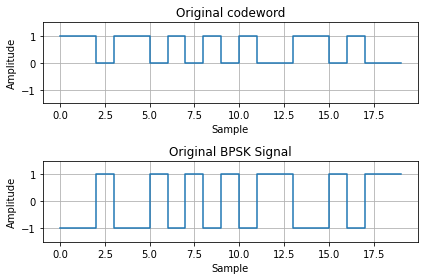

In [9]:
#Modulation: Modulate each codeword block by BPSK modulation.
# 0 -> -1 , 1 -> 1

def BPSK_modulation(input):
    return np.where(input == 0, 1, -1)

u = get_random_info(20)

plt.subplot(2, 1, 1)
plt.plot(u, drawstyle='steps-pre')
plt.title("Original codeword")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.ylim(-1.5, 1.5)
plt.grid(True)

bpsk_signal = BPSK_modulation(u)

plt.subplot(2, 1, 2)
plt.plot(bpsk_signal, drawstyle='steps-pre')
plt.title("Original BPSK Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.tight_layout()
plt.show()


# Transmission: Transmit modulated symbols over
## the AWGN channel with the noise power spectral density 𝑁/2.

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/AWGN.png" />

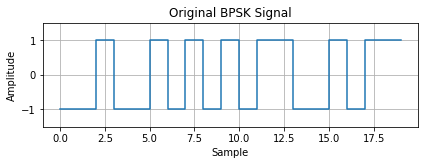

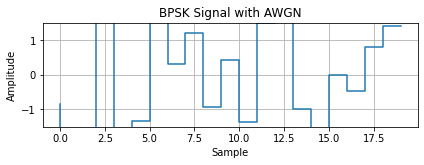

In [10]:
# Transmission: Transmit modulated symbols over
#the AWGN channel with the noise power spectral density 𝑁/2.

def add_awgn_noise(signal, noise_variance ):
    noise = np.random.normal(0, np.sqrt(noise_variance), signal.shape)
    # 변조된 신호에 잡음 추가
    return signal + noise

snr_db = 2
snr = snr_linear = 10 ** (snr_db / 10)
var = 1/2 * 1/r * 1/snr
signal_with_noise = add_awgn_noise(bpsk_signal,var)


plt.subplot(2, 1, 2)
plt.plot(bpsk_signal, drawstyle='steps-pre')
plt.title("Original BPSK Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(signal_with_noise, drawstyle='steps-pre')
plt.title("BPSK Signal with AWGN")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.ylim(-1.5, 1.5)
plt.grid(True)

plt.tight_layout()
plt.show()

# Decoding
## Decode each received codeword by the iterative message passing algorithm


# Check node message update
## func update_ctv

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/check_meesage.png" />

In [11]:
@jit(nopython=True)
def update_ctv(vtc_message, c ,v, v_node_indexes):
    message = 1
    for i in v_node_indexes:
        if i == v:
            continue #ingnore
        message *=  np.tanh(vtc_message[i,c] * 1/2)

    message = np.log((1+message)/(1-message))
    return message

# Variable node message update

## func update_vtc

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/variable_meesage.png" />

In [12]:
@jit(nopython=True)
def update_vtc(ctv_message, v, c, c_node_indexes):

    #get v_message
    tmp = 0
    for i in c_node_indexes:
        if i == c:
            continue #ingnore
        tmp += ctv_message[i,v]

    return tmp

# LLR update

# func update_LLR

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/LLR_meesage.png" />

In [13]:
@jit(nopython=True)
def update_LLR(ctv_message, v, c_node_indexes):
    tmp = 0
    for i in c_node_indexes:
        tmp += ctv_message[i,v]
    return tmp

# Iterative decoding process

<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/iter.png" />
<img src="https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/qv.png" />

In [14]:
#Decoding: Decode each received codeword by the iterative message passing algorithm
# Iterative message passing
# Maximum number of iterations: 50

@jit(nopython=True)
def hamming_distance(matrix1, matrix2):
    distance = np.sum(matrix1 != matrix2)
    return distance

@jit(nopython=True)
def decoding(recived_symbol, H, var):
    max_iter = 10
    H_float64 = H.astype(np.float64)
    v_nodes = 2 * recived_symbol / var

    LLR = np.zeros(v_nodes.shape)
    vtc_message=[]
    ctv_message=[]

    #vertex index
    c_to_v = [np.where(H[i, :] == 1)[0] for i in range(H.shape[0])]
    v_to_c = [np.where(H[:, i] == 1)[0] for i in range(H.shape[1])]

    # 메시지를 넘파이 배열로 저장
    ctv_message = np.zeros((H.shape[0], H.shape[1]))
    vtc_message = np.zeros((H.shape[1], H.shape[0]))

    #Initialization: Assign the channel LLR 𝑞 to variable node 𝑣 as its initial message.
    for v in range(H.shape[1]):
        c_node_indexes = v_to_c[v]
        for c in c_node_indexes:
            vtc_message[v,c] = v_nodes[v]

    for i in range(max_iter):

        #2. Check node message update: check node 𝑐 → variable node
        for c in range(H.shape[0]):
            # c노드와 연결된 v노드 확인
            v_node_indexes= c_to_v[c]
            #c 노드의 연결된 노드 선택
            for v in v_node_indexes :
                ctv_message[c,v] = update_ctv(vtc_message, c, v, v_node_indexes)

        codeword = np.zeros(H.shape[1])
        for v in range(H.shape[1]):
            # v노드와 연결된 c노드 확인
            c_node_indexes= v_to_c[v]
            #v 노드의 연결된 노드 선택
            #3. Variable node message update: variable node 𝑣 → check node c
            for c in c_node_indexes :
                vtc_message[v,c] = v_nodes[v] + update_vtc(ctv_message, v, c, c_node_indexes)

            #4. LLR update: Update LLR at variable node 𝑣.
            LLR[v] = v_nodes[v] + update_LLR(ctv_message, v, c_node_indexes)
            #5. Hard decision of coded bit
            codeword[v] = 0 if LLR[v] > 0 else 1

        #6. Error detection
        result = (H_float64 @ codeword.T) %2
        #print(np.sum(result))
        if np.all(result == 0):
            break

    return codeword


# Misson 1 code

In [15]:
#Step 1
n= 576
r= 1/2
k= int(n*r)

# Parity Check Matrix: Choose a code rate 𝑅 and determine the base matrix
#to be expanded to the parity check matrix 𝐇.
z, b_matrix  = get_base_matrix(n,r)
h_matrix = get_h_matrix(z, b_matrix)

#snrs = np.arange(0.5, 5, 0.5)
snrs_db = np.arange(-1, 2.0, 0.5)
snrs = snr_linear = 10 ** (snrs_db / 10)

ldpc_bit_error_counts = np.zeros_like(snrs)
bpsk_bit_error_counts = np.zeros_like(snrs)
total_bits_counts = np.zeros_like(snrs)
max_bit_errors = 1000  # 각 SNR에 대해 찾을 비트 에러의 최대 수
max_bit_simulated= 100000

for idx, snr in enumerate(snrs):
    ldpc_bit_errors = 0
    bpsk_bit_errors = 0
    total_bits_simulated = 0
    var = 1/2 * 1/r * 1/snr

    #Data generation: Generate an original information block of 𝑘𝑘 bits arbitrarily.
    data = get_random_info(k)
    #Encoding: Encode the original data using the parity check matrix 𝐇 through the efficient encoding procedur
    codeword = encoding_data(data,h_matrix)
    #Modulation: Modulate each codeword block by BPSK modulation.
    bpsk_signal = BPSK_modulation(codeword)

    while ldpc_bit_errors < max_bit_errors or bpsk_bit_errors < max_bit_errors or total_bits_simulated < max_bit_simulated :

        #Transmission: Transmit modulated symbols over the AWGN channel with the noise power spectral density 𝑁𝑁0/2.
        signal_with_noise = add_awgn_noise(bpsk_signal, var)
        #Decoding: Decode each received codeword by the iterative message passing algorithm
        decoded_output = decoding(signal_with_noise, h_matrix, var)
        ldpc_bit_errors += hamming_distance(data, decoded_output[:k])

        #uncoded data
        noisy_data = signal_with_noise[:k]
        uncoded = np.array(noisy_data < 0, dtype=int)
        bpsk_bit_errors += hamming_distance(data, uncoded)

        total_bits_simulated += k

    ldpc_bit_error_counts[idx] = ldpc_bit_errors
    bpsk_bit_error_counts[idx] = bpsk_bit_errors
    total_bits_counts[idx] = total_bits_simulated


# Performance evaluation

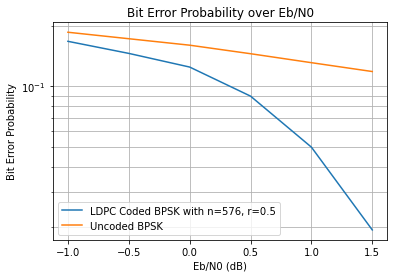

In [16]:
#Performance Evaluation
# 비트 에러 확률 계산
ldpc_bit_error_probabilities = ldpc_bit_error_counts / total_bits_counts
bpsk_bit_error_probabilities = bpsk_bit_error_counts / total_bits_counts

# 비트 에러 확률 플롯
plt.yscale('log')
plt.plot(snrs_db, ldpc_bit_error_probabilities, label='LDPC Coded BPSK with n='+str(n)+', r='+str(r))
plt.plot(snrs_db, bpsk_bit_error_probabilities, label='Uncoded BPSK')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Probability')
plt.title('Bit Error Probability over Eb/N0')
plt.legend()
plt.grid(True, which="both")  # 메이저와 마이너 그리드 모두 표시
plt.show()

# Mission 2
## Encode an image of yourself and decode its noise corrupted version using the LDPC code

# Data gathering
## Read the image (.jpg) to generate the original  data. Each pixel of the image is represented by 8-bits.

In [17]:
def read_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def bits_to_image(bit_set,shape):

    image_array = np.packbits(bit_set.astype(int)).reshape(shape)
    image = Image.fromarray(image_array)

    return image

def blocks_to_bit(blocks,bit_size):
    return blocks.flatten()[:bit_size]

def block_img(data, h):
    codeword_len = h.shape[0]
    data_len = len(data)

    num_blocks = data_len // codeword_len + (data_len % codeword_len != 0)  # 나머지가 있는 경우 1을 더해 마지막 블록 생성

    blocks = np.zeros([num_blocks, codeword_len])

    for i in range(num_blocks):
        start_idx = i * codeword_len
        end_idx = min((i + 1) * codeword_len, data_len)

        block = data[start_idx:end_idx]

        if len(block) < codeword_len:
            padding_len = codeword_len - len(block)
            block = np.concatenate((block, np.zeros(padding_len, dtype=int)))

        blocks[i] = block

    return blocks


# Encoding and Decoding
## Choose a code rate 𝑅 and determine the parity check matrix 𝐇. Then, encode each information block through the efficient encoding procedure.

In [18]:
def ldpc_encode_image_blocks(image_blocks, h_matrix, var):
    num_blocks = len(image_blocks)
    block_len = h_matrix.shape[1]  # 가정: 인코딩된 블록의 길이는 h_matrix의 열 길이와 같음

    # NumPy 배열로 초기화
    encoded_blocks = np.zeros((num_blocks, block_len), dtype=np.float64)
    uncoded_blocks = np.zeros(image_blocks.shape, dtype=np.float64)

    for i in range(num_blocks):
        block = image_blocks[i]
        ldpc_codeword = encoding_data(block, h_matrix)
        ldpc_codeword = BPSK_modulation(ldpc_codeword)
        signal_with_noise = add_awgn_noise(ldpc_codeword, var)

        # NumPy 배열에 값 할당
        encoded_blocks[i] = signal_with_noise
        uncoded_blocks[i] = signal_with_noise[:len(block)]

    return encoded_blocks, uncoded_blocks

def ldpc_decode_image_blocks(encoded_blocks, h_matrix, var):
    num_blocks = encoded_blocks.shape[0]
    block_len = h_matrix.shape[0]
    decoded_result = np.zeros((num_blocks, block_len), dtype=np.float64)

    for i in range(num_blocks):
        decoded_output = decoding(encoded_blocks[i], h_matrix, var)
        decoded_result[i] = decoded_output[:block_len]

    return decoded_result

# Misson 2 Code

In [19]:
# Photo shooting: Take a photo of yourself.
image = read_img('https://raw.githubusercontent.com/smin-k/Digital-Communication-Systems/main/img/input.jpg')

#Data gathering: Read the image (.jpg) to generate the original data.
image_array = np.array(image)
img_shape = image_array.shape
img_bit= np.unpackbits(image_array)

#Information block segmentation: Split the original data into
#multiple information blocks, where each one is of length 𝑘.
img_blocks = block_img(img_bit,h_matrix)

#Demonstration: Show the original and the decoded images of yourself at low and high snr
snrs_db = np.arange(0, 3, 1)
snrs = snr_linear = 10 ** (snrs_db / 10)

uncoded_imgs=[]
decoded_imgs =[]

for idx, snr in enumerate(snrs):
    var = 1/2 * 1/r * 1/snr
    encoded_blocks, uncoded_blocks = ldpc_encode_image_blocks(img_blocks, h_matrix,var)

    decoded_result = ldpc_decode_image_blocks(encoded_blocks, h_matrix, var)
    decoded_bits = blocks_to_bit(decoded_result,len(img_bit))
    decoded_img = bits_to_image(decoded_bits,img_shape)

    uncoded_result = np.array(uncoded_blocks < 0, dtype=int)
    uncoded_bits = blocks_to_bit(uncoded_result,len(img_bit))
    uncoded_img = bits_to_image(uncoded_bits,img_shape)

    uncoded_imgs.append(uncoded_img)
    decoded_imgs.append(decoded_img)


# Performance comparison
## Demonstrate the effect of the coding scheme by comparing the decoded image to the uncoded (received) one at low and high snr

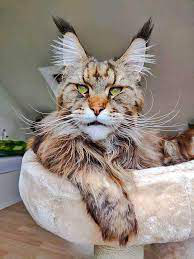

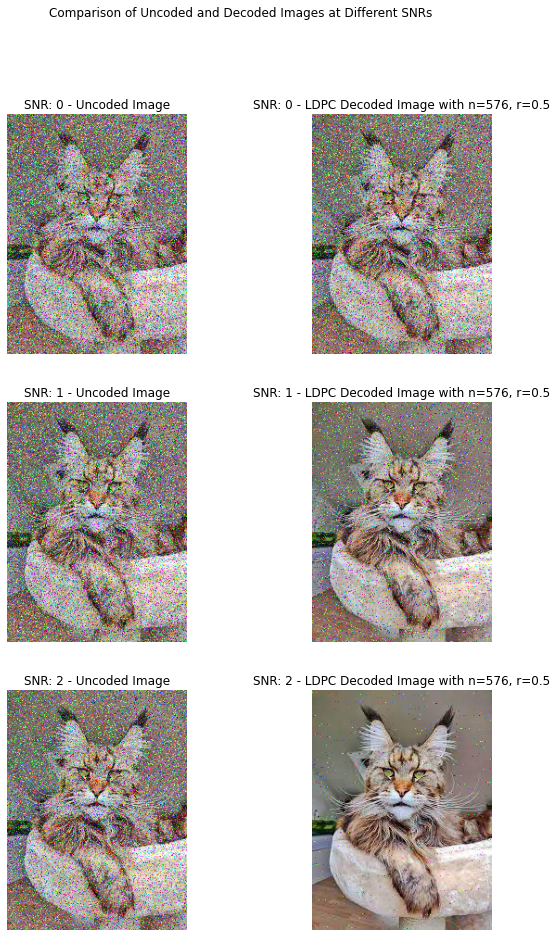

In [20]:
#Performance comparison
display(image)

num_images = len(snrs)
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

for idx in range(num_images):
    # 원본 이미지 표시
    axes[idx, 0].imshow(uncoded_imgs[idx])
    axes[idx, 0].set_title(f"SNR: {snrs_db[idx]} - Uncoded Image")
    axes[idx, 0].axis('off')  # 축 표시 제거

    # 디코딩된 이미지 표시
    axes[idx, 1].imshow(decoded_imgs[idx])
    axes[idx, 1].set_title(f"SNR: {snrs_db[idx]} - LDPC Decoded Image with n="+str(n)+', r='+str(r) )
    axes[idx, 1].axis('off')  # 축 표시 제거

plt.suptitle("Comparison of Uncoded and Decoded Images at Different SNRs")
plt.show()